In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tpot import TPOTRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap


In [2]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from imblearn.over_sampling import SMOTE
from scipy.stats import iqr
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from tpot import TPOTRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../Data/raw_data.csv')
columns_to_drop = ['API','Dose(mg)','Disintegration Stnd Dvt', 'Friability Stnd Dvt', 'Hardness Stnd Dvt', 'Thickness Stnd Dvt']
df = df.drop(columns=columns_to_drop)

### filling Nan values

In [5]:
# in word columss
columns_to_fill = ['Lubricant', 'Binder', 'Filler', 'Disintegrants']
df[columns_to_fill] = df[columns_to_fill].fillna('Null')

# in numeric column 
def fillna_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return series.apply(lambda x: x if (lower_bound <= x <= upper_bound) else series.median())

columns_to_convert = ['Thickness(nm)','Hardness','Friability','Punch']

for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')

for column in columns_to_convert:
    df[column] = df[column].fillna(fillna_iqr(df[column]))

columns_to_fill_with_zero = ['Dose(mg).1', 'Dose(mg).2', 'Dose(mg).3','Dose(mg).4']
for column in columns_to_fill_with_zero:
    df[column] = df[column].fillna(0)

### Sanitising dataset

In [6]:
# Correcting error
df['Filler'] = df['Filler'].replace('Manitol', 'Mannitol')
df.drop(df[df.eq('Q.S').any(axis=1)].index, inplace=True)
word_columns = ['Glidant', 'Lubricant', 'Binder', 'Polymer']

#Redincing the numbers of classes in a column
word_to_replace = ['Avicel','Microcrystalline cellulose','Mannitol']
for word in word_to_replace:
    replace = lambda x: word if x.startswith(word) else x
    for col in word_columns:
        df[col] = df[col].apply(replace)

#stripiing all values of extra spaces
for column in word_columns:
    df[column] = df[column].str.strip()
    df[column] = df[column].str.replace(r'\s+', ' ', regex=True)

### Plotting graphs for reference

In [7]:
def plot_unique():
    unique_value_counts = [len(df[col].unique()) for col in df.columns]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(df.columns, unique_value_counts, color='skyblue')
    plt.title('Count of Unique Values in Columns')
    plt.xlabel('Columns')
    plt.ylabel('Count of Unique Values')
    plt.xticks(rotation=90)
    plt.tight_layout()

    for bar, count in zip(bars, unique_value_counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
                ha='center', va='bottom', fontsize=8)

    plt.show()

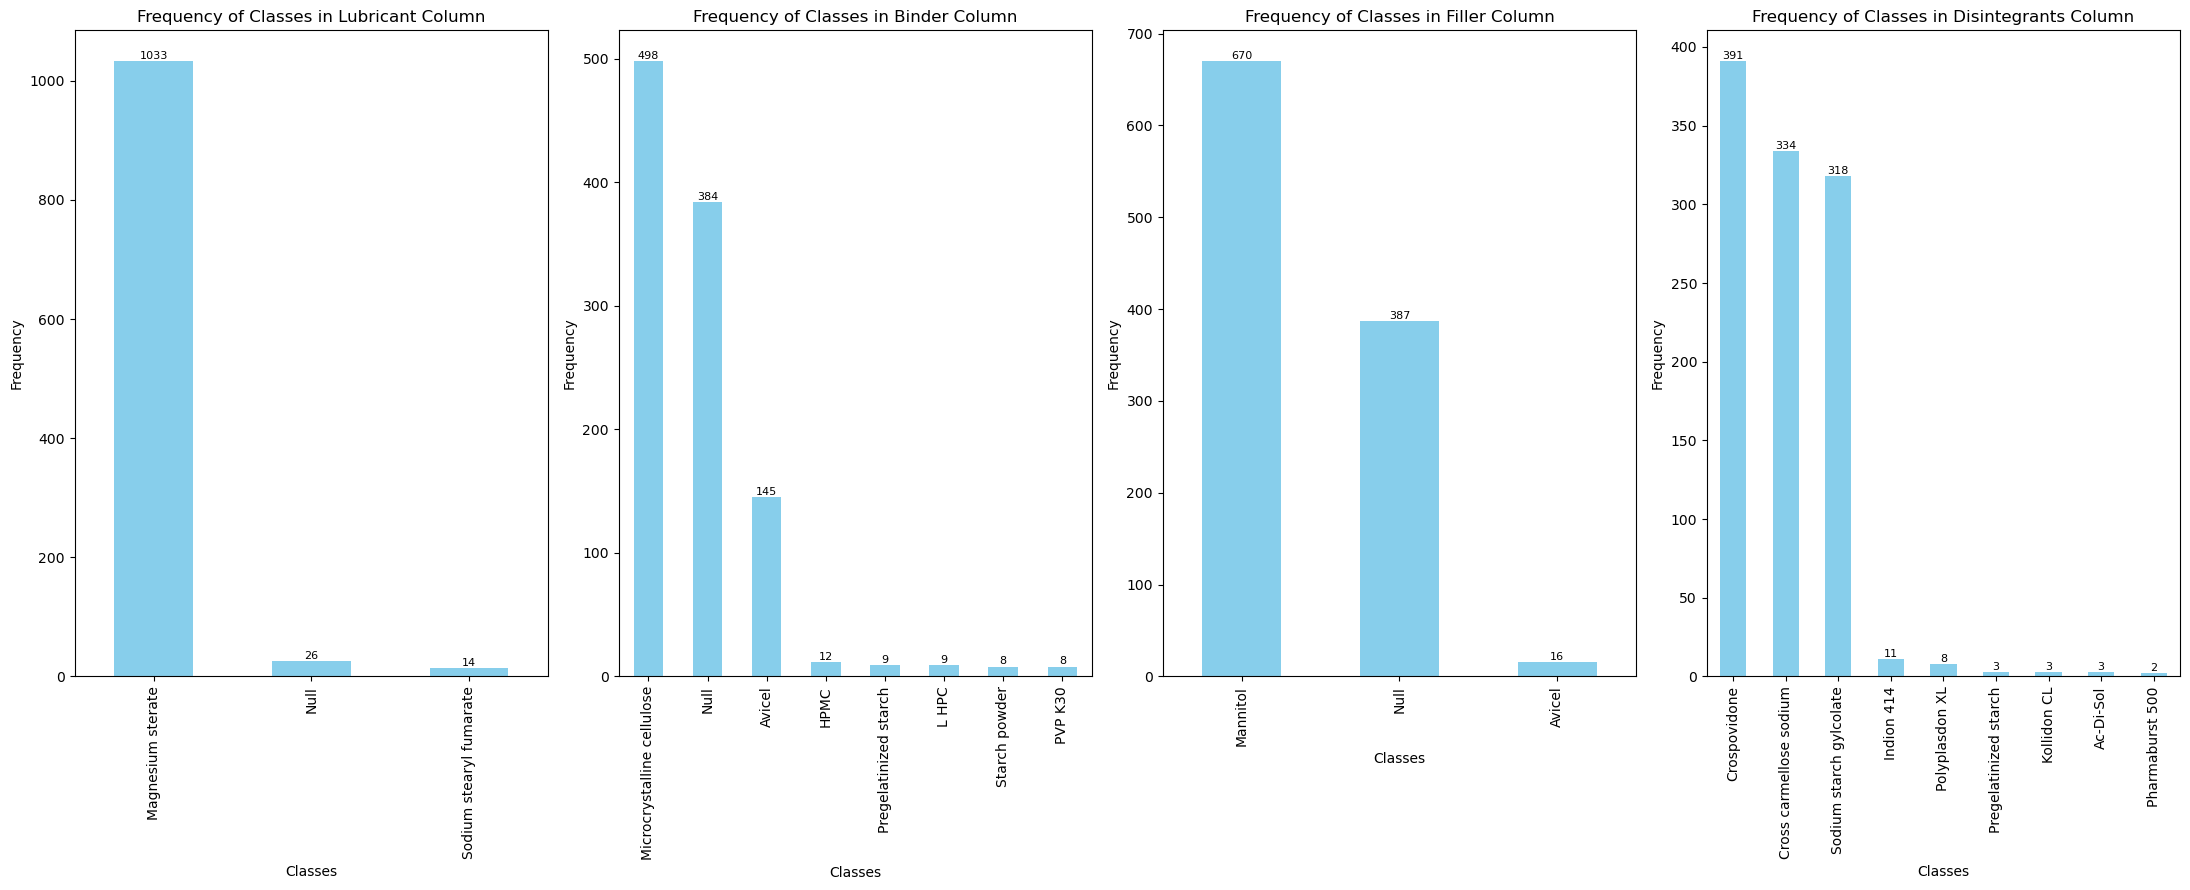

In [8]:
word_columns = ['Lubricant', 'Binder', 'Filler', 'Disintegrants']

# Create subplots for each column side by side
fig, axs = plt.subplots(1, len(word_columns), figsize=(22, 9))

# Plot histograms for each column
for i, column in enumerate(word_columns):
    class_counts = df[column].value_counts()

    bars = class_counts.plot(kind='bar', color='skyblue', ax=axs[i])
    bars.set_title(f'Frequency of Classes in {column} Column')
    bars.set_xlabel('Classes')
    bars.set_ylabel('Frequency')
    bars.set_xticklabels(class_counts.index, rotation=90)

    for j, v in enumerate(class_counts):
        bars.text(j, v + 0.1, str(v), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [9]:
# Dropping unuseful rows 
values_to_keep = ['Crospovidone', 'Sodium starch gylcolate', 'Cross carmellose sodium']
df = df[df['Disintegrants'].isin(values_to_keep)].dropna(subset=['Disintegrants'])

In [10]:
print(df.shape)
print(df.isnull().sum())
df.info()

(1043, 13)
Filler                     0
Dose(mg).1                 0
Binder                     0
Dose(mg).2                 0
Disintegrants              0
Dose(mg).3                 0
Lubricant                  0
Dose(mg).4                 0
Thickness(nm)              0
Hardness                   0
Friability                 0
Punch                      0
Disintegration time (s)    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 1043 entries, 0 to 1074
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Filler                   1043 non-null   object 
 1   Dose(mg).1               1043 non-null   float64
 2   Binder                   1043 non-null   object 
 3   Dose(mg).2               1043 non-null   object 
 4   Disintegrants            1043 non-null   object 
 5   Dose(mg).3               1043 non-null   float64
 6   Lubricant                1043 non-null   object 
 7   Dose(m

### Round of all numerical values

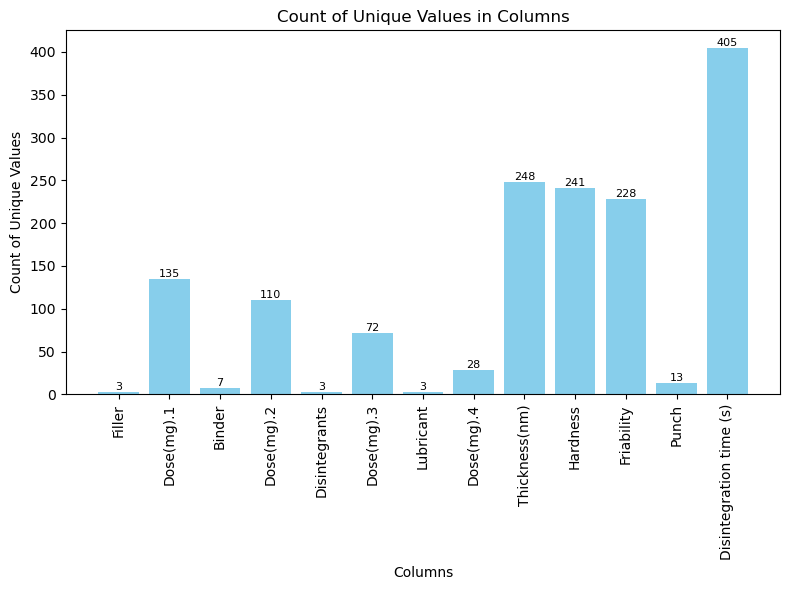

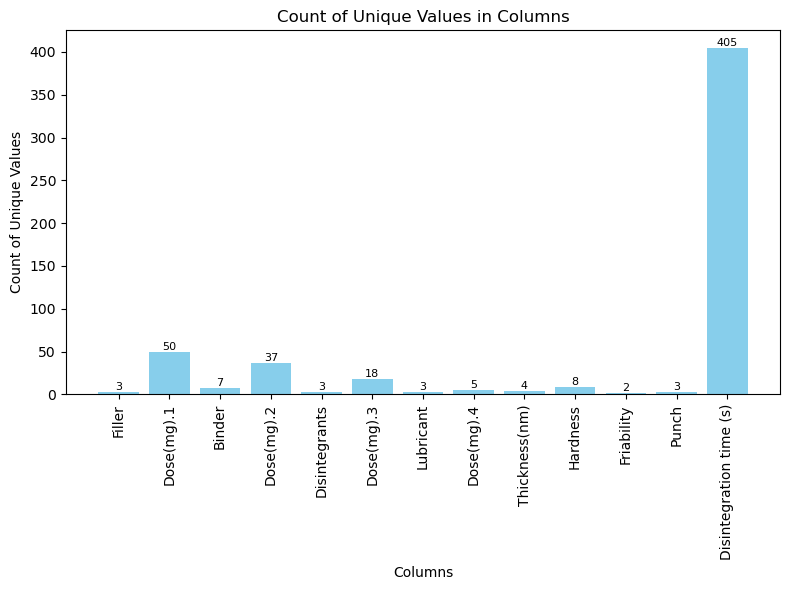

In [11]:
plot_unique()

round_to_closest_5 = lambda x: round(float(x)/5)*5

# Apply rounding off to specified columns
columns_to_round = ['Dose(mg).1', 'Dose(mg).2', 'Dose(mg).3','Dose(mg).4','Thickness(nm)','Hardness','Friability','Punch']
df[columns_to_round] = df[columns_to_round].map(round_to_closest_5)

plot_unique()

In [12]:
df.sample(5)

,Filler,Dose(mg).1,Binder,Dose(mg).2,Disintegrants,Dose(mg).3,Lubricant,Dose(mg).4,Thickness(nm),Hardness,Friability,Punch,Disintegration time (s)
33,Mannitol,50,Avicel,55,Sodium starch gylcolate,10,Magnesium sterate,5,0,5,0,5,124.00
180,Null,0,Avicel,50,Crospovidone,10,Magnesium sterate,5,5,0,0,10,60.00
661,Mannitol,45,Microcrystalline cellulose,25,Sodium starch gylcolate,5,Magnesium sterate,0,5,5,0,10,27.00
760,Mannitol,30,Avicel,40,Cross carmellose sodium,5,Magnesium sterate,0,0,5,0,5,23.00
443,Mannitol,20,Null,0,Cross carmellose sodium,20,Magnesium sterate,5,0,5,0,10,35.32


In [13]:
# Assuming your DataFrame is named df and the columns are properly named
class_column = 'Disintegrants'  # Replace with your actual column name
output_column = 'Disintegration time (s)'  # Replace with your actual column name

grouped = df.groupby(class_column)[output_column].mean().sort_values(ascending=False)
print("Mean values of dependent variable for each class in Disintegrant column:")
print(grouped)


Mean values of dependent variable for each class in Disintegrant column:
Disintegrants
Sodium starch gylcolate    43.662170
Crospovidone               42.863146
Cross carmellose sodium    42.812515
Name: Disintegration time (s), dtype: float64


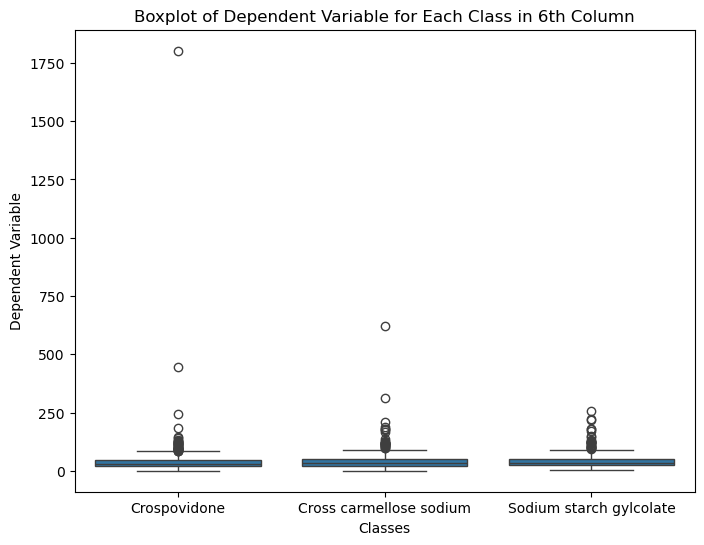

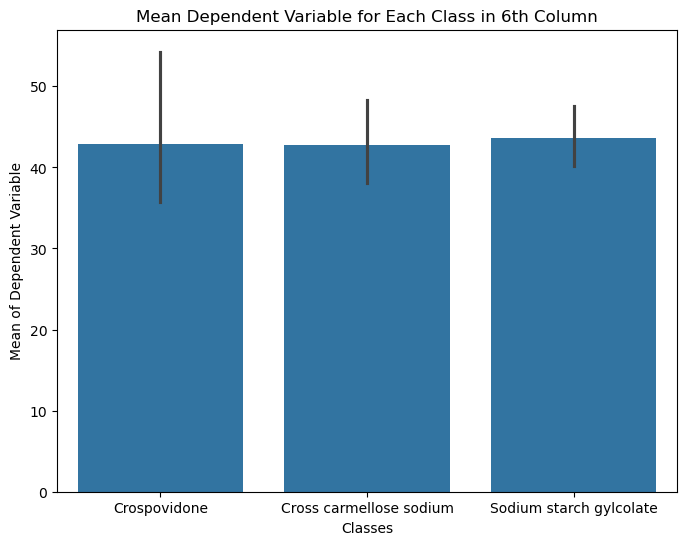

In [14]:
import seaborn as sns

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=class_column, y=output_column, data=df)
plt.title('Boxplot of Dependent Variable for Each Class in 6th Column')
plt.xlabel('Classes')
plt.ylabel('Dependent Variable')
plt.show()

# Barplot (if the number of classes is manageable)
plt.figure(figsize=(8, 6))
sns.barplot(x=class_column, y=output_column, data=df, estimator=np.mean)
plt.title('Mean Dependent Variable for Each Class in 6th Column')
plt.xlabel('Classes')
plt.ylabel('Mean of Dependent Variable')
plt.show()


In [15]:
for i in range(0,3):
    df = df.drop(df.index[i])

Mean values of dependent variable for each class in Disintegrant column:
Disintegrants
Sodium starch gylcolate    42.995489
Cross carmellose sodium    42.812515
Crospovidone               37.307172
Name: Disintegration time (s), dtype: float64


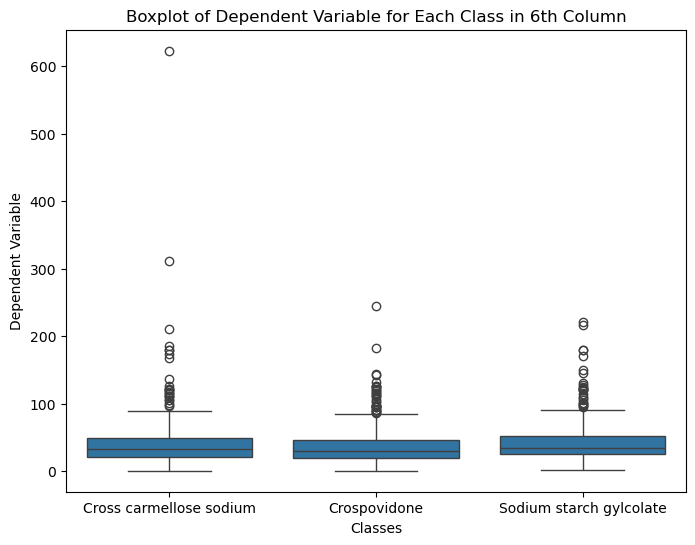

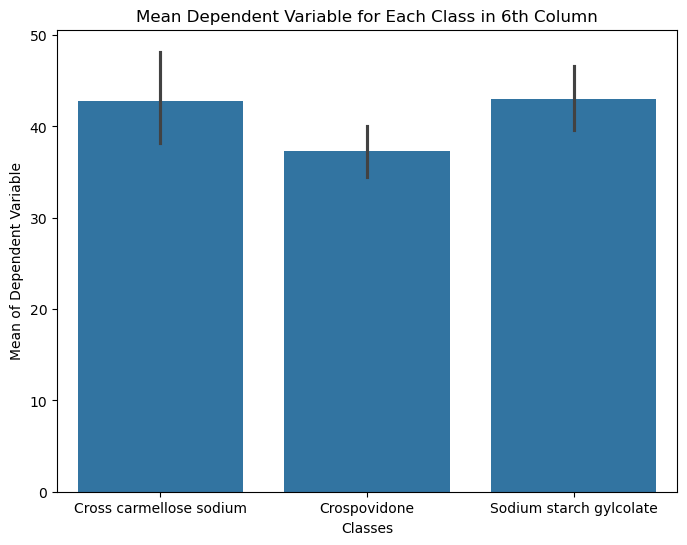

In [16]:
# Assuming your DataFrame is named df and the columns are properly named
class_column = 'Disintegrants'  # Replace with your actual column name
output_column = 'Disintegration time (s)'  # Replace with your actual column name

grouped = df.groupby(class_column)[output_column].mean().sort_values(ascending=False)
print("Mean values of dependent variable for each class in Disintegrant column:")
print(grouped)

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=class_column, y=output_column, data=df)
plt.title('Boxplot of Dependent Variable for Each Class in 6th Column')
plt.xlabel('Classes')
plt.ylabel('Dependent Variable')
plt.show()

# Barplot (if the number of classes is manageable)
plt.figure(figsize=(8, 6))
sns.barplot(x=class_column, y=output_column, data=df, estimator=np.mean)
plt.title('Mean Dependent Variable for Each Class in 6th Column')
plt.xlabel('Classes')
plt.ylabel('Mean of Dependent Variable')
plt.show()

In [17]:
skewness = df[['Dose(mg).1', 'Dose(mg).2', 'Dose(mg).3','Dose(mg).4','Thickness(nm)','Hardness','Friability','Punch']].skew()
print("Skewness of numeric dataset",end = '\n')
print(skewness)

Skewness of numeric dataset
Dose(mg).1        3.172033
Dose(mg).2        2.266196
Dose(mg).3        3.145848
Dose(mg).4        2.969821
Thickness(nm)    10.509435
Hardness          6.972514
Friability       22.770532
Punch            -0.943068
dtype: float64


In [18]:
df_ohe = df
columns_to_OHE = ['Lubricant', 'Binder', 'Filler', 'Disintegrants']
for column in columns_to_OHE:
    one_hot_encoded = pd.get_dummies(df_ohe[column], prefix=column)
    df_ohe = pd.concat([df_ohe, one_hot_encoded.astype(int)], axis=1)

df_ohe.drop(columns=columns_to_OHE, inplace=True)
len(df_ohe.columns)

25

In [19]:
df_ohe.columns

Index(['Dose(mg).1', 'Dose(mg).2', 'Dose(mg).3', 'Dose(mg).4', 'Thickness(nm)',
       'Hardness', 'Friability', 'Punch', 'Disintegration time (s)',
       'Lubricant_Magnesium sterate', 'Lubricant_Null',
       'Lubricant_Sodium stearyl fumarate', 'Binder_Avicel', 'Binder_HPMC',
       'Binder_L HPC', 'Binder_Microcrystalline cellulose', 'Binder_Null',
       'Binder_Pregelatinized starch', 'Binder_Starch powder', 'Filler_Avicel',
       'Filler_Mannitol', 'Filler_Null', 'Disintegrants_Crospovidone',
       'Disintegrants_Cross carmellose sodium',
       'Disintegrants_Sodium starch gylcolate'],
      dtype='object')

In [20]:
# X = df_ohe[['Dose(mg).1', 'Dose(mg).2', 'Dose(mg).3', 'Dose(mg).4', 'Thickness(nm)',
#        'Hardness', 'Friability', 'Punch',
#        'Lubricant_Magnesium sterate', 'Lubricant_Null',
#        'Lubricant_Sodium stearyl fumarate', 'Binder_Avicel', 'Binder_HPMC',
#        'Binder_L HPC', 'Binder_Microcrystalline cellulose', 'Binder_Null',
#        'Binder_Pregelatinized starch', 'Binder_Starch powder', 'Filler_Avicel',
#        'Filler_Mannitol', 'Filler_Null', 'Disintegrants_Crospovidone',
#        'Disintegrants_Cross carmellose sodium',
#        'Disintegrants_Sodium starch gylcolate']]

# y = df_ohe[['Disintegration time (s)']]

# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
# tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
# tpot.fit(X_train,y_train)
# tpot.fitted_pipeline_

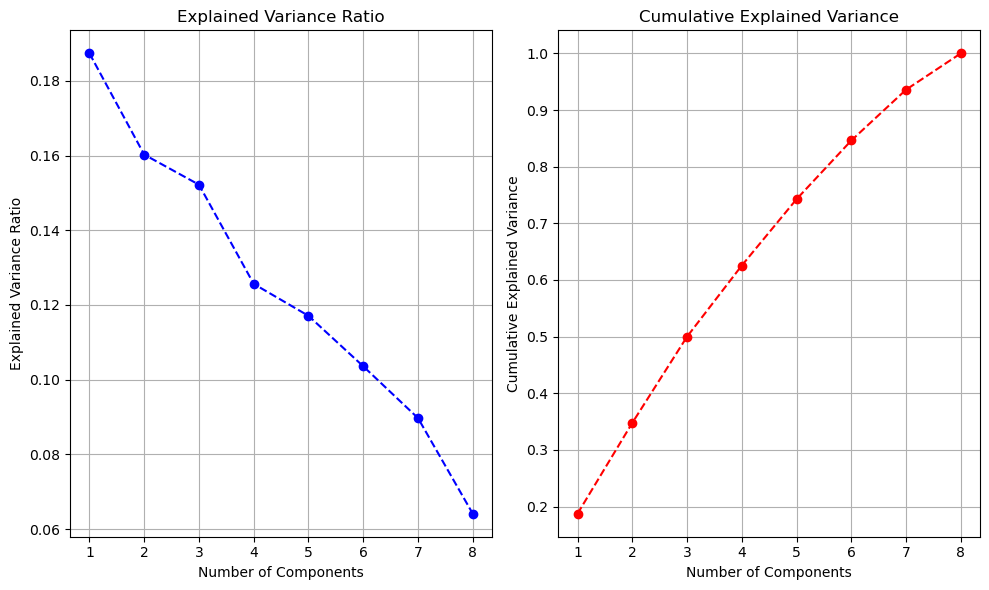

In [21]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Specify the columns for PCA
columns_for_pca = ['Dose(mg).1', 'Dose(mg).2', 'Dose(mg).3', 'Dose(mg).4', 'Thickness(nm)', 'Hardness', 'Friability', 'Punch']

# Extract specified columns for PCA and other columns as is
columns_to_leave = [col for col in df_ohe.columns if col not in columns_for_pca]

# Apply PCA only to specified columns
pca_features = df_ohe[columns_for_pca]

# Standardize the selected columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_features)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
pca.fit(scaled_data)

# Transform the data using the PCA model
pca_result = pca.transform(scaled_data)

# Convert PCA result to DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

# Combine PCA results with the columns left unchanged
df_ohe_pca = pd.concat([pca_df, df_ohe[columns_to_leave]], axis=1)

# Calculate explained variance ratio and cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plotting scree plot
plt.figure(figsize=(10, 6))

# Explained Variance Ratio Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='blue')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
plt.grid(True)

# Cumulative Explained Variance Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', color='red')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(np.arange(1, len(cumulative_explained_variance) + 1))
plt.grid(True)

plt.tight_layout()
plt.show()


In [22]:
df_ohe_pca.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
       'Disintegration time (s)', 'Lubricant_Magnesium sterate',
       'Lubricant_Null', 'Lubricant_Sodium stearyl fumarate', 'Binder_Avicel',
       'Binder_HPMC', 'Binder_L HPC', 'Binder_Microcrystalline cellulose',
       'Binder_Null', 'Binder_Pregelatinized starch', 'Binder_Starch powder',
       'Filler_Avicel', 'Filler_Mannitol', 'Filler_Null',
       'Disintegrants_Crospovidone', 'Disintegrants_Cross carmellose sodium',
       'Disintegrants_Sodium starch gylcolate'],
      dtype='object')

In [23]:

# X = df_ohe_pca[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
#        'Lubricant_Magnesium sterate',
#        'Lubricant_Null', 'Lubricant_Sodium stearyl fumarate', 'Binder_Avicel',
#        'Binder_HPMC', 'Binder_L HPC', 'Binder_Microcrystalline cellulose',
#        'Binder_Null', 'Binder_Pregelatinized starch', 'Binder_Starch powder',
#        'Filler_Avicel', 'Filler_Mannitol', 'Filler_Null',
#        'Disintegrants_Crospovidone', 'Disintegrants_Cross carmellose sodium',
#        'Disintegrants_Sodium starch gylcolate']]

# y = df_ohe_pca[['Disintegration time (s)']]

# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
# tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
# tpot.fit(X_train,y_train)
# tpot.fitted_pipeline_

In [24]:
df_ohe_pca.dropna(inplace=True)
df_ohe_pca.isnull().sum()

PC1                                      0
PC2                                      0
PC3                                      0
PC4                                      0
PC5                                      0
PC6                                      0
PC7                                      0
PC8                                      0
Disintegration time (s)                  0
Lubricant_Magnesium sterate              0
Lubricant_Null                           0
Lubricant_Sodium stearyl fumarate        0
Binder_Avicel                            0
Binder_HPMC                              0
Binder_L HPC                             0
Binder_Microcrystalline cellulose        0
Binder_Null                              0
Binder_Pregelatinized starch             0
Binder_Starch powder                     0
Filler_Avicel                            0
Filler_Mannitol                          0
Filler_Null                              0
Disintegrants_Crospovidone               0
Disintegran

Mean Squared Error: 983.12
Root Mean Squared Error: 31.35
Mean Absolute Error: 20.16
R-squared: 0.06

Feature Importances:
                                  Feature  Importance
11                        Filler_Mannitol    0.155754
1                          Lubricant_Null    0.144244
14  Disintegrants_Cross carmellose sodium    0.085254
0             Lubricant_Magnesium sterate    0.077234
15  Disintegrants_Sodium starch gylcolate    0.075555
6       Binder_Microcrystalline cellulose    0.072687
10                          Filler_Avicel    0.059992
12                            Filler_Null    0.059177
7                             Binder_Null    0.051873
13             Disintegrants_Crospovidone    0.049521
4                             Binder_HPMC    0.042216
3                           Binder_Avicel    0.041385
2       Lubricant_Sodium stearyl fumarate    0.036391
5                            Binder_L HPC    0.020269
9                    Binder_Starch powder    0.020098
8            

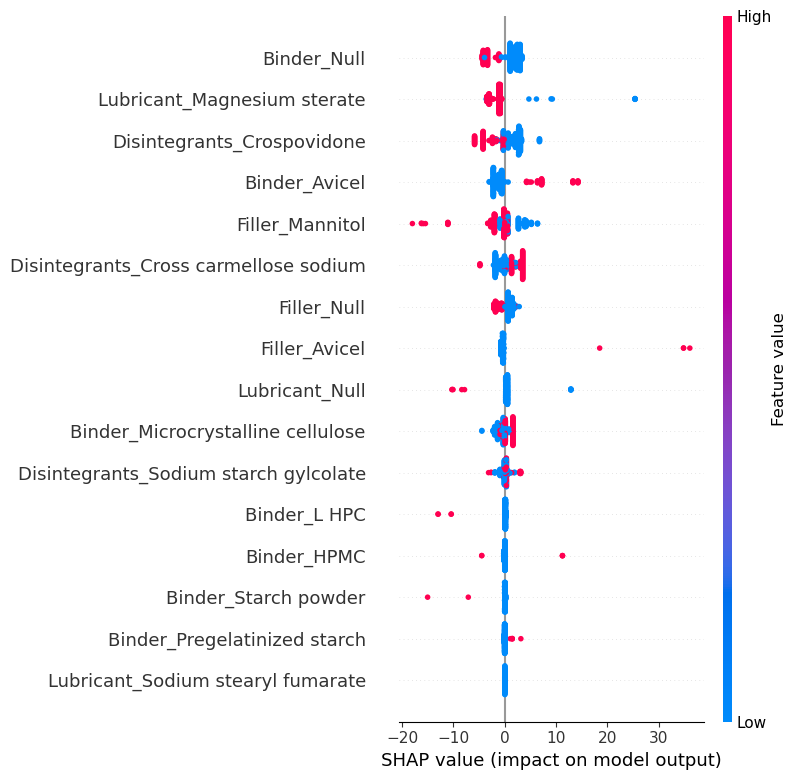

In [62]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import shap
import matplotlib.pyplot as plt

# ... (assuming df_ohe and other dataframes are defined)

# Your feature names
# features = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
features = [
       'Lubricant_Magnesium sterate',
       'Lubricant_Null', 'Lubricant_Sodium stearyl fumarate', 'Binder_Avicel',
       'Binder_HPMC', 'Binder_L HPC', 'Binder_Microcrystalline cellulose',
       'Binder_Null', 'Binder_Pregelatinized starch', 'Binder_Starch powder',
       'Filler_Avicel', 'Filler_Mannitol', 'Filler_Null',
       'Disintegrants_Crospovidone', 'Disintegrants_Cross carmellose sodium',
       'Disintegrants_Sodium starch gylcolate']

# Your X and y
X = df_ohe_pca[features]
y = df_ohe_pca['Disintegration time (s)']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Train your model (XGBRegressor)
clf = xgb.XGBRegressor(learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=100, n_jobs=1, objective='reg:squarederror', subsample=0.7500000000000001, verbosity=0, random = 0)
# clf = xgb.XGBRegressor()
# clf = RandomForestRegressor()
# clf = RandomForestRegressor(bootstrap=False, max_features=0.45, min_samples_leaf=3, min_samples_split=6, n_estimators=100)
# clf = DecisionTreeRegressor()
# clf = ExtraTreesRegressor()
# clf = GradientBoostingRegressor()


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {np.sqrt(mse):.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R-squared: {r2:.2f}')

# Feature Importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': clf.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(importance_df)

most_important_feature = importance_df.iloc[0]['Feature']
most_important_importance = importance_df.iloc[0]['Importance']
print(f"\nMost Important Feature: {most_important_feature}")
print(f"Importance Value: {most_important_importance}")

import shap
shap.initjs()

# SHAP plots
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
base_values = explainer.expected_value
feature_names = X_test.columns
explanation = shap.Explanation(shap_values, base_values, feature_names)

# # Summary plot - bar plot
# shap.summary_plot(shap_values, X_test, plot_type="bar")

# Summary plot - dot plot
shap.summary_plot(shap_values, X_test)

# # beeswarm
# cmap = plt.cm.Spectral
# color_values = cmap(np.linspace(0.0, 1.0, len(explanation)))
# shap.plots.beeswarm(explanation, color=color_values)

# # Force plot for a specific instance (e.g., the first instance)
# shap.force_plot(explainer.expected_value, shap_values)

# # Dependence plot for a specific feature (e.g., 'Disintegrants_Crospovidone')
# shap.dependence_plot('Disintegrants_Sodium starch gylcolate', shap_values, X_test)

# # Waterfall plot for a specific instance (e.g., the first instance)
# # shap.plots.Waterfall(explainer.expected_value, shap_values, features = ['Disintegrants_Sodium starch gylcolate'])
# 
# plt.show()

# shap.plots.force(explainer.expected_value, shap_values, features = ['Disintegrants_Sodium starch gylcolate'])

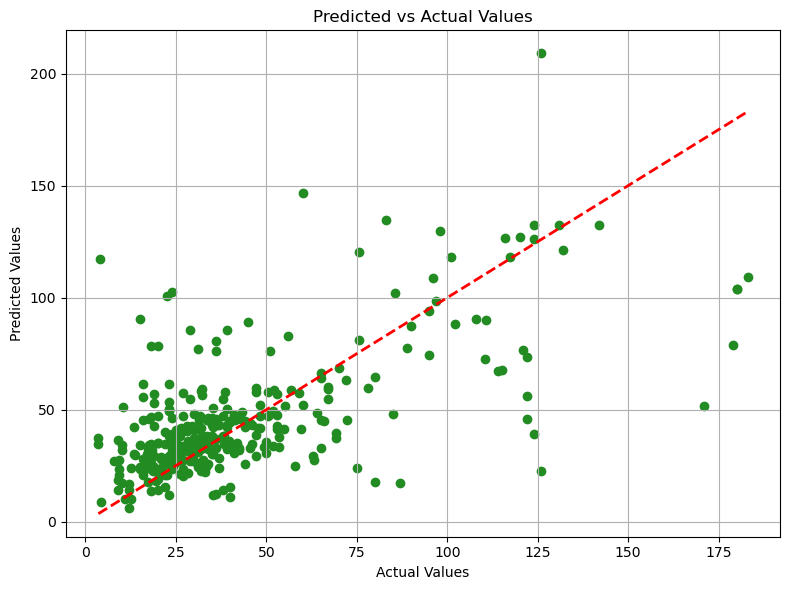

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color= 'forestgreen' )
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)  # Diagonal line
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# Feature Importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': clf.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(importance_df)

# Extract SHAP feature importance values for specified features
disintegrant_features = ['Disintegrants_Cross carmellose sodium', 'Disintegrants_Sodium starch gylcolate', 'Disintegrants_Crospovidone']
shap_importance_values = importance_df[importance_df['Feature'].isin(disintegrant_features)]['Importance'].values

# Create a new dataframe to store SHAP importance values
hist = pd.DataFrame({'XGB': shap_importance_values}, index=disintegrant_features)
print(hist)



Feature Importances:
                                  Feature  Importance
8             Lubricant_Magnesium sterate    0.112274
3                                     PC4    0.082517
6                                     PC7    0.078310
2                                     PC3    0.069931
7                                     PC8    0.069423
4                                     PC5    0.065970
0                                     PC1    0.064912
18                          Filler_Avicel    0.063426
19                        Filler_Mannitol    0.057908
5                                     PC6    0.041485
9                          Lubricant_Null    0.039151
1                                     PC2    0.037906
22  Disintegrants_Cross carmellose sodium    0.037560
14      Binder_Microcrystalline cellulose    0.034722
21             Disintegrants_Crospovidone    0.034301
23  Disintegrants_Sodium starch gylcolate    0.030261
15                            Binder_Null    0.020898
12    

In [41]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Train your model (XGBRegressor)
# clf = xgb.XGBRegressor(learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=100, n_jobs=1, objective='reg:squarederror', subsample=0.7500000000000001, verbosity=0, random = 0)
# clf = xgb.XGBRegressor()
# clf = RandomForestRegressor()
# clf = RandomForestRegressor(bootstrap=False, max_features=0.45, min_samples_leaf=3, min_samples_split=6, n_estimators=100)
clf = DecisionTreeRegressor()
# clf = ExtraTreesRegressor()
# clf = GradientBoostingRegressor()


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {np.sqrt(mse):.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R-squared: {r2:.2f}')

# Feature Importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': clf.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(importance_df)

most_important_feature = importance_df.iloc[0]['Feature']
most_important_importance = importance_df.iloc[0]['Importance']
print(f"\nMost Important Feature: {most_important_feature}")
print(f"Importance Value: {most_important_importance}")

import shap
shap.initjs()

# SHAP plots
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
base_values = explainer.expected_value
feature_names = X_test.columns
explanation = shap.Explanation(shap_values, base_values, feature_names)

# Feature Importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': clf.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(importance_df)

# Extract SHAP feature importance values for specified features
disintegrant_features = ['Disintegrants_Cross carmellose sodium', 'Disintegrants_Sodium starch gylcolate', 'Disintegrants_Crospovidone']
shap_importance_values = importance_df[importance_df['Feature'].isin(disintegrant_features)]['Importance'].values

# Create a new dataframe to store SHAP importance values
hist = pd.DataFrame({'XGB': shap_importance_values}, index=disintegrant_features)
print(hist)

Mean Squared Error: 1832.18
Root Mean Squared Error: 42.80
Mean Absolute Error: 17.94
R-squared: 0.11

Feature Importances:
                                  Feature  Importance
3                                     PC4    0.167732
0                                     PC1    0.132430
6                                     PC7    0.093559
5                                     PC6    0.089809
1                                     PC2    0.083470
4                                     PC5    0.077669
7                                     PC8    0.066634
14      Binder_Microcrystalline cellulose    0.060055
2                                     PC3    0.043013
20                            Filler_Null    0.039643
19                        Filler_Mannitol    0.033086
21             Disintegrants_Crospovidone    0.027062
11                          Binder_Avicel    0.019436
8             Lubricant_Magnesium sterate    0.019398
18                          Filler_Avicel    0.013644
15          


Feature Importances:
                                  Feature  Importance
3                                     PC4    0.167732
0                                     PC1    0.132430
6                                     PC7    0.093559
5                                     PC6    0.089809
1                                     PC2    0.083470
4                                     PC5    0.077669
7                                     PC8    0.066634
14      Binder_Microcrystalline cellulose    0.060055
2                                     PC3    0.043013
20                            Filler_Null    0.039643
19                        Filler_Mannitol    0.033086
21             Disintegrants_Crospovidone    0.027062
11                          Binder_Avicel    0.019436
8             Lubricant_Magnesium sterate    0.019398
18                          Filler_Avicel    0.013644
15                            Binder_Null    0.011646
23  Disintegrants_Sodium starch gylcolate    0.010767
22  Di

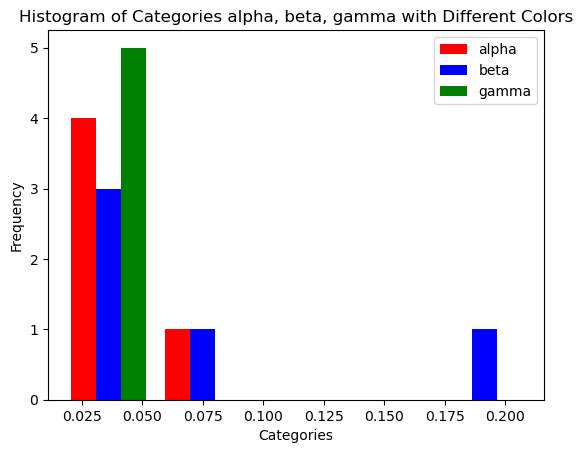

In [48]:
import matplotlib.pyplot as plt

# Provided data
v1 = [0.051207, 0.033813, 0.022164]
v2 = [0.027957, 0.023715, 0.038523]
v3 = [0.09041, 0.08667, 0.049523]
v4 = [0.026534, 0.026534, 0.016615]
v5 = [0.027062, 0.210706, 0.02861]

# Prepare data for each category (alpha, beta, gamma)
alpha = [v1[0], v2[0], v3[0], v4[0], v5[0]]
beta = [v1[1], v2[1], v3[1], v4[1], v5[1]]
gamma = [v1[2], v2[2], v3[2], v4[2], v5[2]]

# Assign different colors to each dataset
colors = ['red', 'blue', 'green']

# Plot histogram with different colors for each category
plt.hist([alpha, beta, gamma], bins=5, color=colors, label=['alpha', 'beta', 'gamma'])
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Histogram of Categories alpha, beta, gamma with Different Colors')
plt.legend()

# Display the histogram
plt.show()


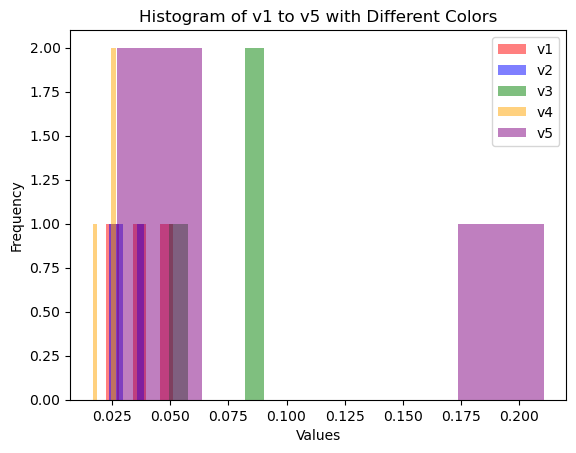

In [46]:
import matplotlib.pyplot as plt

# Provided data
v1 = [0.051207, 0.033813, 0.022164]
v2 = [0.027957, 0.023715, 0.038523]
v3 = [0.09041, 0.08667, 0.049523]
v4 = [0.026534, 0.026534, 0.016615]
v5 = [0.027062, 0.210706, 0.02861]

# Combine the lists
data = [v1, v2, v3, v4, v5]

# Assign colors for each dataset
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Plot each dataset with a different color
for i, dataset in enumerate(data):
    plt.hist(dataset, bins=5, alpha=0.5, color=colors[i], label=f'v{i+1}')

# Labeling and legend
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of v1 to v5 with Different Colors')
plt.legend()

# Show the plot
plt.show()
